In [3]:
import pandas as pd
import re
import json
# Read the JSON file
with open('datasets/val.json', 'r') as f:
    val_data = pd.read_json(f)

# Read the JSON file
with open('val_predictions.json', 'r') as f:
    val_predictions = pd.read_json(f)

# Convert to CSV format
# Create DataFrame from val_data
val_df = pd.DataFrame(val_data)
val_predictions_df = pd.DataFrame(val_predictions)

# Read the old val CSV file
old_val_df = pd.read_csv('old_val.csv')

# Delete existing non_lora_response column if it exists
if 'non_lora_response' in val_predictions_df.columns:
    val_predictions_df = val_predictions_df.drop('non_lora_response', axis=1)

# Add the non_lora_response column from old_val.csv to val_predictions_df 
val_predictions_df = pd.concat([val_predictions_df, old_val_df['non_lora_response']], axis=1)

# Add column for synopsis length (number of strings in the list)
val_predictions_df['synopsis_len'] = val_predictions_df['synopsis'].apply(len)


val_predictions_df.head()


,narrative_id,source,title,synopsis,turning_points,arc_label,tp_pred_reasoning,lora_response,non_lora_response,synopsis_len
0,67134190,Human,Dolphin Island (film),[10 years after losing her parents David and D...,"{'tp1': 4.0, 'tp2': 8.0, 'tp3': 14.0, 'tp4': 1...",Man in Hole,### Review of the Story\nThe story revolves ar...,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...",26
1,62877295,Human,Chick Fight,[Anna Wyncomb works in a coffee shop and her d...,"{'tp1': 3.0, 'tp2': 6.0, 'tp3': 9.0, 'tp4': 15...",Cinderella,### Review of the Story\n\nThe story revolves ...,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...",29
2,62334733,Human,Palmer (film),[Eddie Palmer is a former high school football...,"{'tp1': 2.0, 'tp2': 4.0, 'tp3': 19.0, 'tp4': 1...",Cinderella,### Review of the Story\nThe story revolves ar...,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...",28
3,59400313,GPT,Hilarious Minds,[The movie begins with a captivating scene tha...,"{'tp1': 6.0, 'tp2': 11.0, 'tp3': 15.0, 'tp4': ...",Rags to Riches,### Review of the Story\nThe story revolves ar...,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...",31
4,67321742,Human,Bodies Bodies Bodies,"[Bee, a working-class young woman from Eastern...","{'tp1': 4.0, 'tp2': 7.0, 'tp3': 15.0, 'tp4': 2...",Riches to Rags,### Review of the Story\nThe story revolves ar...,"Below is an instruction that describes a task,...","Below is an instruction that describes a task,...",32


In [5]:
# Extract JSON from both response columns using the extract_json function from fix_val_predictions.py
def extract_json(text):
    """Extract JSON-formatted turning points from text."""
    if pd.isna(text):
        return None
        
    # Look for JSON pattern with either single or double quotes
    # Pattern for single-line JSON
    json_pattern_single = r'\{(?:["\']tp\d+["\']:\s*\d+(?:\.\d+)?(?:,\s*["\']tp\d+["\']:\s*\d+(?:\.\d+)?)*)\}'
    # Pattern for multi-line formatted JSON with optional whitespace and newlines
    json_pattern_multi = r'\{\s*(?:["\']tp\d+["\']:\s*\d+(?:\.\d+)?(?:\s*,\s*["\']tp\d+["\']:\s*\d+(?:\.\d+)?)*\s*)\}'
    
    # Try both patterns
    match = re.search(json_pattern_single, text)
    if not match:
        match = re.search(json_pattern_multi, text)
    
    if not match:
        return None
        
    try:
        # Replace single quotes with double quotes for valid JSON
        json_str = match.group(0).replace("'", '"')
        return json.loads(json_str)
    except json.JSONDecodeError:
        return None

# Add the extracted JSON columns
val_predictions_df['extracted_tp_non_lora'] = val_predictions_df['non_lora_response'].apply(extract_json)
val_predictions_df['extracted_tp_lora'] = val_predictions_df['lora_response'].apply(extract_json)



Statistical Analysis for each turning point:
--------------------------------------------------------------------------------------------------------------------------------------------
TP             Non-LoRA           LoRA        Ground Truth    t-stat (L vs NL)     p-val (L vs NL)    t-stat (L vs GT)     p-val (L vs GT)
--------------------------------------------------------------------------------------------------------------------------------------------
1                 0.069          0.129               0.140               4.562               0.000              -0.893               0.373
2                 0.193          0.257               0.276               1.882               0.062              -0.287               0.775
3                 0.393          0.438               0.460               2.130               0.035              -0.530               0.597
4                 0.564          0.639               0.615               3.438               0.001               1.5

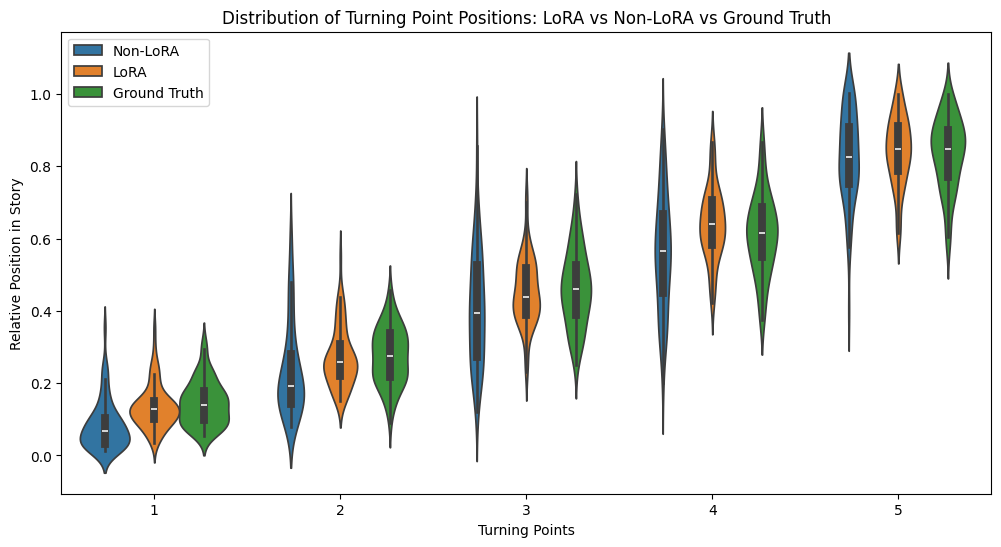

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create lists to store the normalized positions
non_lora_positions = {f'tp{i}': [] for i in range(1,6)}
lora_positions = {f'tp{i}': [] for i in range(1,6)}
ground_truth_positions = {f'tp{i}': [] for i in range(1,6)}

# Extract and normalize the positions
for idx, row in val_predictions_df.iterrows():
    if pd.notna(row['extracted_tp_non_lora']):
        tp_dict = eval(row['extracted_tp_non_lora']) if isinstance(row['extracted_tp_non_lora'], str) else row['extracted_tp_non_lora']
        for tp in range(1,6):
            key = f'tp{tp}'
            if key in tp_dict:
                non_lora_positions[key].append(tp_dict[key] / row['synopsis_len'])
                
    if pd.notna(row['extracted_tp_lora']):
        tp_dict = eval(row['extracted_tp_lora']) if isinstance(row['extracted_tp_lora'], str) else row['extracted_tp_lora']
        for tp in range(1,6):
            key = f'tp{tp}'
            if key in tp_dict:
                lora_positions[key].append(tp_dict[key] / row['synopsis_len'])
                
    if pd.notna(row['turning_points']):
        tp_dict = eval(row['turning_points']) if isinstance(row['turning_points'], str) else row['turning_points']
        for tp in range(1,6):
            key = f'tp{tp}'
            if key in tp_dict:
                ground_truth_positions[key].append(tp_dict[key] / row['synopsis_len'])

# Calculate and print statistics for each turning point
print("\nStatistical Analysis for each turning point:")
print("-" * 140)
print(f"{'TP':<8}{'Non-LoRA':>15}{'LoRA':>15}{'Ground Truth':>20}{'t-stat (L vs NL)':>20}{'p-val (L vs NL)':>20}{'t-stat (L vs GT)':>20}{'p-val (L vs GT)':>20}")
print("-" * 140)

for tp in range(1,6):
    key = f'tp{tp}'
    non_lora_median = np.median(non_lora_positions[key]) if non_lora_positions[key] else float('nan')
    lora_median = np.median(lora_positions[key]) if lora_positions[key] else float('nan')
    ground_median = np.median(ground_truth_positions[key]) if ground_truth_positions[key] else float('nan')
    
    # Perform t-tests
    # LoRA vs Non-LoRA
    t_stat_lora_vs_non, p_val_lora_vs_non = stats.ttest_ind(lora_positions[key], non_lora_positions[key]) if (lora_positions[key] and non_lora_positions[key]) else (float('nan'), float('nan'))
    
    # LoRA vs Ground Truth
    t_stat_lora_vs_ground, p_val_lora_vs_ground = stats.ttest_ind(lora_positions[key], ground_truth_positions[key]) if (lora_positions[key] and ground_truth_positions[key]) else (float('nan'), float('nan'))
    
    print(f"{tp:<8}{non_lora_median:>15.3f}{lora_median:>15.3f}{ground_median:>20.3f}{t_stat_lora_vs_non:>20.3f}{p_val_lora_vs_non:>20.3f}{t_stat_lora_vs_ground:>20.3f}{p_val_lora_vs_ground:>20.3f}")

# Additional statistics
print("\nAdditional Statistics:")
print("-" * 50)
for tp in range(1,6):
    key = f'tp{tp}'
    print(f"\nTurning Point {tp}:")
    
    # Calculate mean absolute error from ground truth
    if ground_truth_positions[key] and lora_positions[key]:
        lora_mae = np.mean([abs(l - g) for l, g in zip(lora_positions[key], ground_truth_positions[key])])
        print(f"LoRA MAE from Ground Truth: {lora_mae:.3f}")
    
    if ground_truth_positions[key] and non_lora_positions[key]:
        non_lora_mae = np.mean([abs(n - g) for n, g in zip(non_lora_positions[key], ground_truth_positions[key])])
        print(f"Non-LoRA MAE from Ground Truth: {non_lora_mae:.3f}")
    
    # Calculate standard deviations
    print(f"LoRA std: {np.std(lora_positions[key]):.3f}")
    print(f"Non-LoRA std: {np.std(non_lora_positions[key]):.3f}")
    print(f"Ground Truth std: {np.std(ground_truth_positions[key]):.3f}")

# Create the violin plot
data_to_plot = []
labels = []
positions = []

for tp in range(1,6):
    key = f'tp{tp}'
    data_to_plot.extend(non_lora_positions[key])
    data_to_plot.extend(lora_positions[key])
    data_to_plot.extend(ground_truth_positions[key])
    labels.extend(['Non-LoRA']*len(non_lora_positions[key]))
    labels.extend(['LoRA']*len(lora_positions[key]))
    labels.extend(['Ground Truth']*len(ground_truth_positions[key]))
    positions.extend([tp]*len(non_lora_positions[key]))
    positions.extend([tp]*len(lora_positions[key]))
    positions.extend([tp]*len(ground_truth_positions[key]))

plt.figure(figsize=(12, 6))
sns.violinplot(x=positions, y=data_to_plot, hue=labels)
plt.xlabel('Turning Points')
plt.ylabel('Relative Position in Story')
plt.title('Distribution of Turning Point Positions: LoRA vs Non-LoRA vs Ground Truth')
plt.show()


Below is a high-level explanation of what each part of the table and statistics mean, and how you might interpret them in plain language.

1. Overview of the Table

Statistical Analysis for each turning point:
------------------------------------------------------------------------------------------
TP   Non-LoRA   LoRA   Ground Truth   t-stat (L vs NL)  p-val (L vs NL)  t-stat (L vs GT)  p-val (L vs GT)
------------------------------------------------------------------------------------------
1       0.069   0.129       0.140           4.562            0.000           -0.893            0.373
2       0.193   0.257       0.276           1.882            0.062           -0.287            0.775
3       0.393   0.438       0.460           2.130            0.035           -0.530            0.597
4       0.564   0.639       0.615           3.438            0.001            1.538            0.127
5       0.826   0.846       0.847           0.898            0.371            0.405            0.687

Columns Explained
	1.	TP: Stands for “Turning Point” index (1 through 5).
	2.	Non-LoRA: The mean (or average) predicted turning-point value by the Non-LoRA model (the model without LoRA fine-tuning).
	3.	LoRA: The mean predicted turning-point value by the LoRA-fine-tuned model.
	4.	Ground Truth: The actual (true) turning-point value in your dataset (the “gold standard”).
	5.	t-stat (L vs NL): The t-statistic from a statistical test comparing the LoRA predictions vs. the Non-LoRA predictions.
	6.	p-val (L vs NL): The p-value from that same test, telling you whether LoRA’s predictions are statistically different from Non-LoRA’s predictions.
	7.	t-stat (L vs GT): The t-statistic comparing the LoRA predictions vs. Ground Truth.
	8.	p-val (L vs GT): The p-value telling you if LoRA’s predictions are significantly different from the ground truth.

How to Interpret the t-stat / p-value
	•	A p-value under a common threshold like 0.05 generally implies a statistically significant difference.
	•	A positive t-stat typically means the first group’s mean is higher than the second; a negative t-stat implies it’s lower. (Context can vary depending on your test design.)

Looking at Turning Point 1 (TP1):
	•	Non-LoRA Mean = 0.069
	•	LoRA Mean = 0.129
	•	Ground Truth Mean = 0.140
	•	t-stat (L vs NL) = 4.562, p-val = 0.000
→ LoRA’s predictions differ significantly from Non-LoRA’s (p < .05).
	•	t-stat (L vs GT) = -0.893, p-val = 0.373
→ No significant difference compared to ground truth (p > .05).

In plain language for TP1: LoRA predictions are significantly different from Non-LoRA predictions but not significantly different from the actual ground truth—that’s good news for LoRA if your goal is to match the ground truth more closely.

2. Additional Statistics (MAE and Standard Deviations)

Turning Point 1:
LoRA MAE from Ground Truth: 0.050
Non-LoRA MAE from Ground Truth: 0.075
LoRA std: 0.060
Non-LoRA std: 0.067
Ground Truth std: 0.061

Turning Point 2:
LoRA MAE from Ground Truth: 0.071
Non-LoRA MAE from Ground Truth: 0.112
LoRA std: 0.082
Non-LoRA std: 0.128
Ground Truth std: 0.078

... and so on for TPs 3, 4, 5 ...

MAE (Mean Absolute Error)
	•	MAE from Ground Truth measures how far, on average, the model’s predictions are from the true value. A lower MAE means more accurate predictions.
	•	Comparing LoRA vs. Non-LoRA MAE:
	•	For TP1: LoRA = 0.050, Non-LoRA = 0.075
→ LoRA is more accurate (smaller MAE).
	•	For TP2: LoRA = 0.071, Non-LoRA = 0.112
→ Again, LoRA is more accurate, and so on.

Standard Deviation (std)
	•	LoRA std and Non-LoRA std: How spread out each model’s predictions are.
	•	A lower std means the predictions are more consistent (less variance).
	•	Ground Truth std: The variability in the ground truth turning points themselves across your dataset.

In most rows, LoRA std is smaller than or comparable to Non-LoRA std, indicating LoRA’s predictions are both (a) closer on average to the ground truth and (b) more consistent in their predictions.

3. Putting It All Together
	1.	Accuracy Gains:
	•	The LoRA model generally has a lower MAE compared to Non-LoRA, implying it’s closer to the ground truth.
	•	The top table’s “t-stat (L vs GT)” columns show that LoRA is often not significantly different from ground truth—also a good sign.
	2.	Statistical Significance:
	•	“t-stat (L vs NL)” and “p-val (L vs NL)” indicate where LoRA’s predictions differ statistically from Non-LoRA’s.
	•	For Turning Points 1–4, you see mostly p < 0.05, suggesting LoRA differs from Non-LoRA in a meaningful way.
	•	For TP5, LoRA vs. Non-LoRA is not significantly different (p = 0.371), meaning both models perform roughly the same for that turning point.
	3.	Consistency:
	•	LoRA’s standard deviations (std) are generally lower or on par with Non-LoRA, which suggests less variance in LoRA’s predictions (i.e., more consistent performance across data samples).
	4.	Implication:
	•	LoRA is consistently closer to the ground truth (lower MAE), significantly different (improved) from Non-LoRA for most turning points, and not significantly different from ground truth on all but possibly one or two TPs (where p-value is borderline).
	•	In short, LoRA is producing more accurate and stable predictions for these turning points relative to the Non-LoRA approach.

Example Takeaway

	“The LoRA model yields statistically significant improvements over the Non-LoRA model for Turning Points 1–4 (p < 0.05). Moreover, LoRA’s predictions are not significantly different from the ground truth for most turning points—indicating it’s matching the real data well. The MAE and standard deviation comparisons further confirm LoRA’s advantage in accuracy (lower MAE) and consistency (lower std). Only for Turning Point 5 do both models perform similarly, with no significant difference between them.”

Bottom Line
	•	Higher-level message: LoRA outperforms (or at least equals) Non-LoRA in predicting these turning points, with statistical evidence backing that up.
	•	Use of these stats: You can confidently claim that LoRA enhancements likely provided a meaningful improvement in predicting the location of turning points according to your ground truth data.